## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src='https://drive.google.com/uc?id=1dzwpEQ5DdrXJCdstIkEaiwHdgIETASni' width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

ml212yz

Your full name:

Yi Zhou

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import optim

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
import re
import csv
from numpy.linalg import norm

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="https://drive.google.com/uc?id=1pOYnuzlsShgztM4hQtBH6flWhtkqB23-" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [3]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!
        model = models.resnet50(pretrained=True)
        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)
        self.encoder = nn.Sequential(*list(model.children())[:-1])
        for param in self.encoder.parameters():
            param.require_grad = False

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.encoder(images)
        # TO COMPLETE
        # remember no gradients are needed
        return features 

In [4]:
# instantiate encoder and put into evaluation mode.
# Your code here!
encoder = EncoderCNN().to(device)
encoder.eval()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

EncoderCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(6

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [5]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/kaggle/input/coco-sub/COMP5625M_data_assessment_2/coco_subset_meta.csv")
#imageList['file_name']
#len(imageList.id.unique())

#imagesUnique = sorted(imageList['file_name'].unique())
#print(len(imagesUnique))

#df_unique_files =  pd.DataFrame.from_dict(imagesUnique)
#df_unique_files.columns = ['file_name']
df_unique_files = imageList[['file_name','id']].drop_duplicates().sort_values(by=['id'])
print(len(df_unique_files))
df_unique_files

5068


file_name      id
4503  000000000009.jpg       9
2308  000000000025.jpg      25
5814  000000000030.jpg      30
2207  000000000034.jpg      34
24    000000000036.jpg      36
...                ...     ...
2882  000000581906.jpg  581906
896   000000581909.jpg  581909
5455  000000581913.jpg  581913
3165  000000581921.jpg  581921
1798  000000581929.jpg  581929

[5068 rows x 2 columns]

In [7]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch 

IMAGE_DIR = "/kaggle/input/coco-sub/COMP5625M_data_assessment_2/coco/images"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        # --> your code here!
        self.transform = transform


    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        imageID = self.df.iloc[index]['id']
        # --> your code here!
        img_loc = os.path.join(IMAGE_DIR, filename)
        image = Image.open(img_loc).convert('RGB')
        image = self.transform(image)
        
        return image, imageID

    def __len__(self):
        return len(self.df)

In [8]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Your code here-->
dataset = COCOImagesDataset(df_unique_files, data_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
print(dataset[0][1])

9


In [9]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this
#only need the features from last conv layer

features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

#with torch.no_grad(): ---->>>>>already use in EncoderCNN()!!!
# ---> Your code here!  
for data in dataloader:
    images, imageIDs = data
    images = images.to(device)
    
    features = encoder(images)
    #print(features.size()) ---> torch.Size([128, 2048, 1, 1])
    
    for i in range(len(imageIDs)):
        imageID = imageIDs[i].item()
        #print(features[i].size()) ----> torch.Size([2048, 1, 1])
        features_map[imageID]= features[i]
        
with open('features_map.csv',mode='w',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(features_map.keys())
    writer.writerow(features_map.values())
#torch.save(features_map,path='/kaggle/working/')

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="https://drive.google.com/uc?id=1TeOIWdxF_UXBrP6mCoolPN0ff4A222Z5" alt="images matched to caption" width="700"/>

In [5]:
import json

# loading captions for training
with open('/kaggle/input/coco-sub/COMP5625M_data_assessment_2/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...

In [6]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/kaggle/input/coco-sub/COMP5625M_data_assessment_2/coco_subset_meta.csv")
# --> your code here! - name the new dataframe as "new_file"
new_file = pd.merge(df, coco_subset[['file_name','id']],left_on='image_id',right_on='id')
new_file = new_file.rename(columns={'id_x':'id'})
new_file = new_file.drop(columns=['id_y']).drop_duplicates(subset=['id']).sort_values(by=['image_id','id'])
#new_file.drop(columns=['id_y']).head()
new_file.head(10)

image_id      id                                            caption  \
27547         9  661611  Closeup of bins of food that include broccoli ...   
27550         9  661977  A meal is presented in brightly colored plasti...   
27553         9  663627  there are containers filled with different kin...   
27556         9  666765  Colorful dishes holding meat, vegetables, frui...   
27559         9  667602         A bunch of trays that have different food.   
16580        25  122312    A giraffe eating food from the top of the tree.   
16581        25  127076               A giraffe standing up nearby a tree    
16582        25  127238      A giraffe mother with its baby in the forest.   
16583        25  133058       Two giraffes standing in a tree filled area.   
16584        25  133676  A giraffe standing next to a forest filled wit...   

              file_name  
27547  000000000009.jpg  
27550  000000000009.jpg  
27553  000000000009.jpg  
27556  000000000009.jpg  
27559  000000000009.jpg  
16580  000000000025.jpg  
16581  000000000025.jpg  
16582  000000000025.jpg  
16583  000000000025.jpg  
16584  000000000025.jpg

#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="https://drive.google.com/uc?id=1k-ZcjPObWH924Li8B9rqDALFaAeGohJH" alt="images matched to caption" width="700"/>

In [7]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Remove spaces in the beginning and at the end
    # Convert to lower case
    # Replace all non-alphabet cpharacters with space
    # Replace all continuous spaces with a single space

    # -->your code here
    caption = df['caption']
    caption = caption.str.strip()
    caption = caption.str.lower()
    caption = caption.replace(to_replace=r'[^a-zA-Z]', value=' ', regex=True)
    clean_caption = caption.apply(lambda x: re.sub('\s+',' ', x))
    # add to dataframe
    df["clean_caption"] = clean_caption

    return df

In [8]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

image_id      id                                            caption  \
27547         9  661611  Closeup of bins of food that include broccoli ...   
27550         9  661977  A meal is presented in brightly colored plasti...   
27553         9  663627  there are containers filled with different kin...   
27556         9  666765  Colorful dishes holding meat, vegetables, frui...   
27559         9  667602         A bunch of trays that have different food.   
16580        25  122312    A giraffe eating food from the top of the tree.   
16581        25  127076               A giraffe standing up nearby a tree    
16582        25  127238      A giraffe mother with its baby in the forest.   
16583        25  133058       Two giraffes standing in a tree filled area.   
16584        25  133676  A giraffe standing next to a forest filled wit...   

              file_name                                      clean_caption  
27547  000000000009.jpg  closeup of bins of food that include broccoli ...  
27550  000000000009.jpg  a meal is presented in brightly colored plasti...  
27553  000000000009.jpg  there are containers filled with different kin...  
27556  000000000009.jpg  colorful dishes holding meat vegetables fruit ...  
27559  000000000009.jpg         a bunch of trays that have different food   
16580  000000000025.jpg    a giraffe eating food from the top of the tree   
16581  000000000025.jpg                a giraffe standing up nearby a tree  
16582  000000000025.jpg      a giraffe mother with its baby in the forest   
16583  000000000025.jpg       two giraffes standing in a tree filled area   
16584  000000000025.jpg  a giraffe standing next to a forest filled wit...

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [9]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [10]:
image_id_list = new_file['image_id'].unique()
train_id,val_id,test_id = split_ids(image_id_list)

In [11]:
train_set = new_file[new_file['image_id'].isin(train_id)]
val_set = new_file[new_file['image_id'].isin(val_id)]
test_set = new_file[new_file['image_id'].isin(test_id)]
train_set.head()

image_id      id                                            caption  \
16580        25  122312    A giraffe eating food from the top of the tree.   
16581        25  127076               A giraffe standing up nearby a tree    
16582        25  127238      A giraffe mother with its baby in the forest.   
16583        25  133058       Two giraffes standing in a tree filled area.   
16584        25  133676  A giraffe standing next to a forest filled wit...   

              file_name                                      clean_caption  
16580  000000000025.jpg    a giraffe eating food from the top of the tree   
16581  000000000025.jpg                a giraffe standing up nearby a tree  
16582  000000000025.jpg      a giraffe mother with its baby in the forest   
16583  000000000025.jpg       two giraffes standing in a tree filled area   
16584  000000000025.jpg  a giraffe standing next to a forest filled wit...

#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [12]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [13]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    #for index, id in enumerate(df_ids):
    for id in df_ids['image_id']:
        #caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        caption = str(new_file.loc[new_file['image_id']==id].iloc[0]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        if word_mapping[word]>MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab

In [14]:
# build your vocabulary for train, valid and test sets
# ---> your code here!
train_vocab = build_vocab(train_set,new_file)
val_vocab = build_vocab(val_set,new_file)
test_vocab = build_vocab(test_set,new_file)

print(train_vocab('the'))

8


In [15]:
def merge_vocab(vocabs):
    merge_vocab = Vocabulary()
    words = set()
    for vocab in vocabs:
        for word in vocab.word2idx:
            if word not in words:
                merge_vocab.add_word(word)
                words.add(word)
    return merge_vocab

final_vocab = merge_vocab([train_vocab, val_vocab])
print(final_vocab('the'))

8


#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [21]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)--> set_df(from new_file)
            features: image features
            vocab: vocabulary wrapper
           
        """
        # TO COMPLETE
        self.df = df
        self.features = {k:v for k,v in features.items() if k in df['image_id'].values}
        self.vocab = vocab
    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
       # TO COMPLETE
        # tensor features:[2048,1,1]-->[1,2048] /// key:id,value:feature /// id == df['id']
        features_k = list(self.features.keys())
        features_v = list(self.features.values())
        features = features_v[index].view(1,-1)
        features_tensor = torch.tensor(features)
        
        # caption word ids /// 1feature -> n caption[feature_key==image_id]
        for cap in self.df.loc[self.df['image_id']==features_k[index], 'clean_caption']:
            caption = []
            for word in cap.split():
                caption.append(self.vocab(word))
            caption.append(self.vocab('<end>'))
            
            #get real length includ <end>
            length = len(caption)
            length_tensor = torch.tensor(length)
            
            #fill <pad> to 47
            for i in range(MAX_SEQ_LEN-length):
                caption.append(self.vocab('<pad>'))
            caption_tensor = torch.tensor(caption)
            
            return (features_tensor, caption_tensor, length_tensor)
    
    
    def __len__(self):
        return len(self.features)
    

In [22]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
# --> Your code here
# Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: x[2], reverse=True)

    features,captions,lengths = zip(*data)
    # merge images (from tuple of 3D tensor to 4D tensor).
    # if using features, 2D tensor to 3D tensor. (batch_size, 256)
    images = torch.stack(features,0)
        
    # merge captions (from tuple of 1D tensor to 2D tensor).    
    # pad with zeros ---> already pad in COCO_Features
    targets = torch.stack(captions,0)
    lengths = torch.stack(lengths,0)
        
    return images, targets, lengths

In [23]:
batch_size = 64

dataset_train = COCO_Features(
    df=train_set,
    vocab=final_vocab,
    features=features_map
)
#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!
dataloader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, collate_fn=caption_collate_fn)

# Do the same as above for your validation set
# ---> your code here!
dataset_val = COCO_Features(
    df=val_set,
    vocab=final_vocab,
    features=features_map
)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=batch_size, collate_fn=caption_collate_fn)

Load one batch of the training set and print out the shape of each returned Tensor.

In [24]:
data = iter(dataloader_train)
features, captions, lengths = next(data)

print('Shape of features tensor: ', features.shape)
print('Shape of captions tensor: ', captions.shape)
print('Shape of lengths tensor: ', lengths.shape)

Shape of features tensor:  torch.Size([64, 1, 2048])
Shape of captions tensor:  torch.Size([64, 47])
Shape of lengths tensor:  torch.Size([64])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        # your code
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        # your code
        self.bn = nn.BatchNorm1d(embed_size,momentum=0.01)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.LSTM(input_size=embed_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        # --> your code
        self.linear = nn.Linear(hidden_size,vocab_size)

       
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = im_features.reshape(im_features.size(0),-1)
        #print('resize_features: ',im_features.shape)
        im_features = self.bn(im_features)
        
        # compute your feature embeddings
        # your code
        features = torch.cat((im_features.unsqueeze(1),embeddings),1)
    
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = nn.utils.rnn.pack_padded_sequence(features,lengths,batch_first=True)
        
        hiddens,_ = self.rnn(packed)
        #outputs,_ = nn.utils.rnn.pad_packed_sequence(hiddens, batch_first=True)
        outputs = self.linear(hiddens[0]) #hint: use a hidden layers in parenthesis
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [16]:
# instantiate decoder
# your code here!
vocab_size = len(final_vocab)
decoder = DecoderRNN(vocab_size=vocab_size).to(device)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [41]:
def train(model,opt,loss_fn,dataloader):
    model.train()
    train_loss = 0.0
    n = 0
    
    for i, data in enumerate(dataloader):
        features, captions, lengths = data
        features = features.to(device)
        captions = captions.to(device)
        #lengths = lengths.to(device)
        
        targets = nn.utils.rnn.pack_padded_sequence(captions,lengths,batch_first=True)[0]
        #print('target: ',targets)
        opt.zero_grad()
        outputs = model(features,captions,lengths)
        #print('outputs: ',outputs)
        loss = loss_fn(outputs,targets)
        loss.backward()
        opt.step()
        
        train_loss += loss.item()
        n += 1

    ltrn = train_loss/n
    return ltrn

In [42]:
def val(model,opt,loss_fn,dataloader):
    model.eval()
    val_loss = 0.0
    n = 0
    
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            features,captions,lengths = data
            features = features.to(device)
            captions = captions.to(device)
            #lengths = lengths.to(device)
            
            targets = nn.utils.rnn.pack_padded_sequence(captions,lengths,batch_first=True)[0]
            #print('val_target: ',targets)
            
            outputs = model(features,captions,lengths)
            #print('val_outputs: ',outputs)
            val_loss += loss_fn(outputs,targets).item()
            n += 1
    ltst = val_loss/n
    return ltst

In [43]:
def draw(df):
    plt.figure(figsize=(3,3),dpi=150)
    
    plt.plot(df['step'],df['train_loss'],label = 'training loss')
    plt.plot(df['step'],df['val_loss'],label = 'validation loss')
    plt.legend(fontsize=6)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss')
    
    plt.show()

In [44]:
def checkpoint(state,filename='decoder_checkpoint'):
    torch.save(state, filename)

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    decoder.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch,loss

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


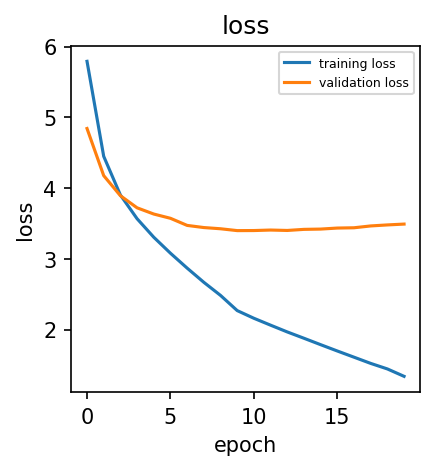

In [45]:
epoches = 50
lr = 0.0008

datasave = pd.DataFrame(columns=['step','train_loss','val_loss'])
opt = optim.Adam(decoder.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

#early stop
best_loss = float('inf')
counter = 0
patience = 10
delta = 0.01

scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size=10,gamma=0.5)
for epoch in range(epoches):
    scheduler.step()
    ltrn = train(decoder,opt,loss_fn,dataloader_train)
    ltst = val(decoder,opt,loss_fn,dataloader_val)
    datasave = datasave.append({'step':epoch,'train_loss':ltrn,'val_loss':ltst},ignore_index=True)
    
    #save checkpoint
    checkpoint({
        'epoch':epoch+1,
        'model_state_dict':decoder.state_dict(),
        'optimizer_state_dict':opt.state_dict(),
        'loss':ltrn})
    
    #early stop
    if ltst<best_loss-delta:
        best_loss = ltst
        counter = 0
    else:
        counter += 1
        if counter>=patience:
            break
    
draw(datasave)

#### Comment about the stopping point
During the training process, an early stopping method was applied. Specifically, the training was halted if the loss value did not decrease for ten consecutive epochs.

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [113]:
# 5 images ->random catch 5 test_id, find features_map'key -> features_map[value]:[2048,1,1]->[1,2048]
# features fed in decoder.sample()
# find 5 ids' images，df_unique_files catch file_name

In [46]:
def test(image_id,feature_map,model,vocab):
    #get feature
    feature = features_map[image_id]
    feature = feature.view(1,-1)
    feature = feature.to(device)
    with torch.no_grad():
        sample_ids = model.sample(feature)[0].cpu().numpy()
    
    #ids ----> words
    captions = []
    for word_id in sample_ids:
        word = vocab.idx2word[word_id]
        captions.append(word)
        if word == '<end>':
            break
    return captions

[450695, 524710, 8228, 254003, 469085]


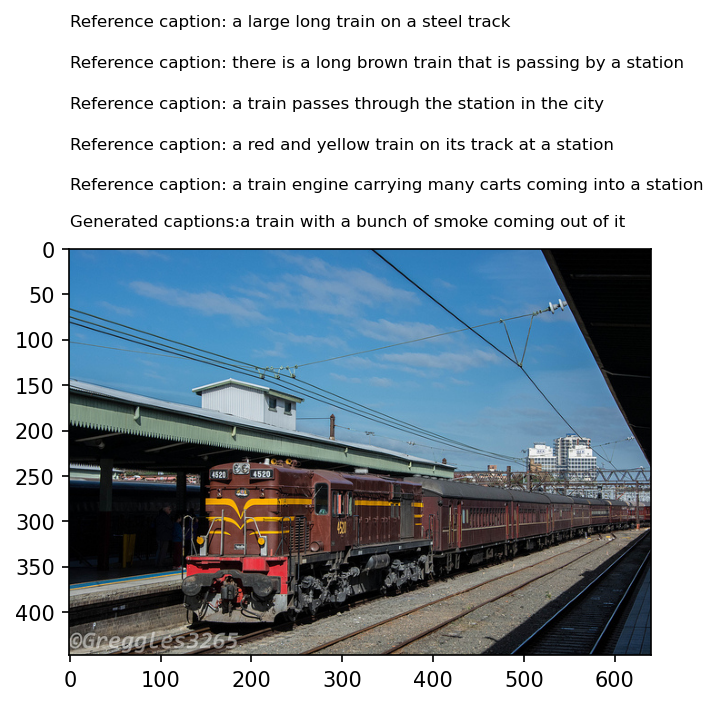

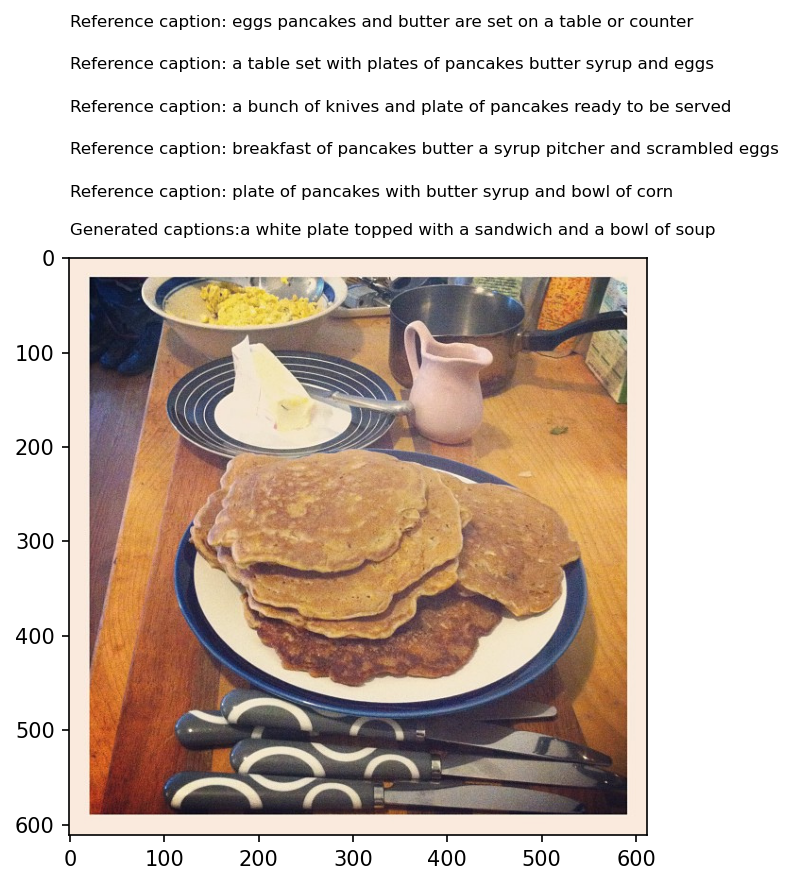

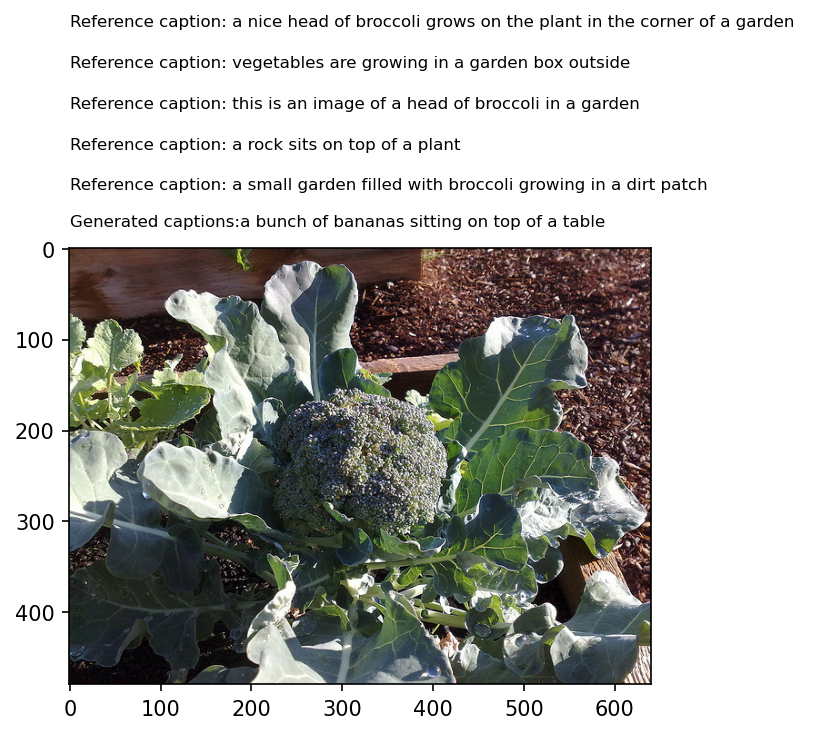

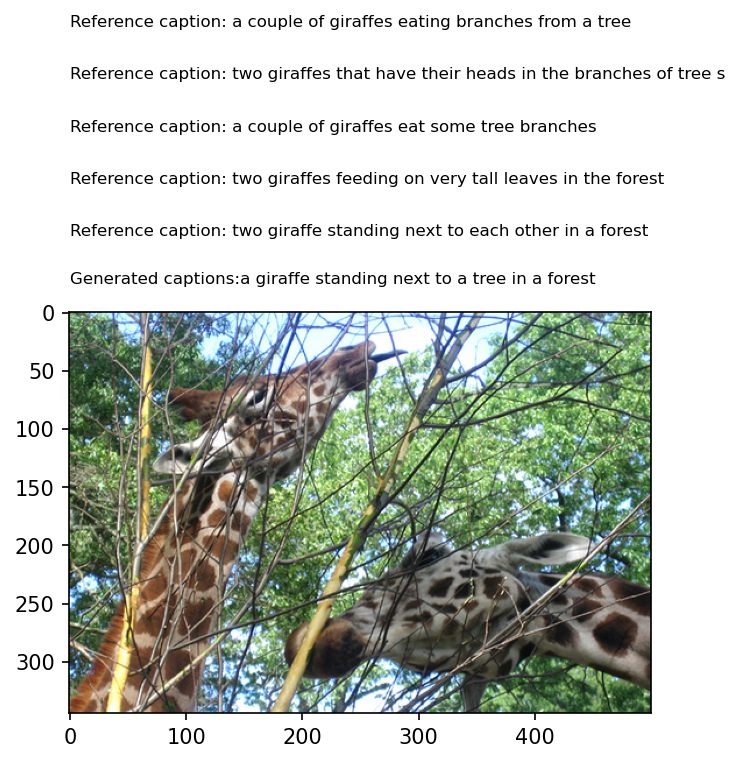

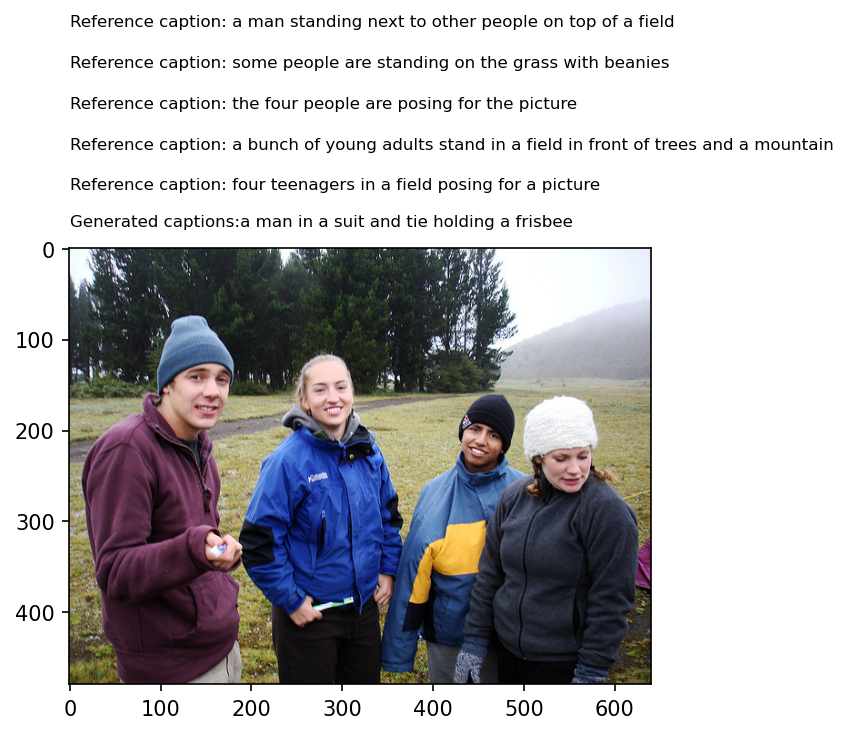

In [48]:
image_5 = random.sample(test_id.tolist(),5)
print(image_5)

for i in range(len(image_5)):
    plt.figure(i+1,figsize=(5,5),dpi=150)
    
    image_id = image_5[i]
    captions = test(image_id,features_map,decoder,final_vocab)[:-1]
    sentence = ' '.join(captions)
    refs = test_set['clean_caption'][test_set['image_id']==image_id]
    
    #open Img and print sentence
    file_name = df_unique_files['file_name'][df_unique_files['id']==image_id].item()
    img_loc = os.path.join(IMAGE_DIR, file_name)
    image = Image.open(img_loc)
    plt.imshow(np.asarray(image))
    for j,ref in enumerate(refs):
        plt.text(0,-250+45*j,'Reference caption: {}'.format(ref),va='center',fontsize=8)
    plt.text(0,-25,'Generated captions:'+ sentence,fontsize=8)
    plt.show()

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [49]:
# TO COMPLETE
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()

# --> Your code here!
for i in range(len(test_id)):
    reference=[]
    refList = test_set['clean_caption'][test_set['image_id']==test_id[i]]
    reference.extend([x.split() for x in refList])
    #print('ref:',reference)
    captions = test(test_id[i],features_map,decoder,final_vocab)[:-1]
    #print('cap:',captions)
    bleu = sentence_bleu(reference,captions)
    
    stats = stats.append({'ref':reference,'preds':captions,'bleu':bleu},ignore_index=True)
stats.head()

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


ref  \
0  [[a, man, trimming, the, nails, of, a, sheep, ...   
1  [[an, upside, down, skateboarder, at, the, top...   
2  [[a, small, stuffed, bear, with, a, red, hat],...   
3  [[two, men, standing, in, a, field, holding, a...   
4  [[there, are, three, flowers, in, vases, by, a...   

                                               preds      bleu  cos_sim  
0  [a, group, of, brown, horses, standing, next, ...  0.795271      NaN  
1  [a, man, with, a, baseball, bat, while, holdin...  0.508133      NaN  
2  [a, man, and, woman, sitting, at, a, table, wi...  0.417226      NaN  
3  [a, man, and, a, woman, standing, next, to, a,...  0.313142      NaN  
4  [a, white, vase, filled, with, flowers, and, a...  0.776545      NaN

Average BLEU score: 0.5183677153854863


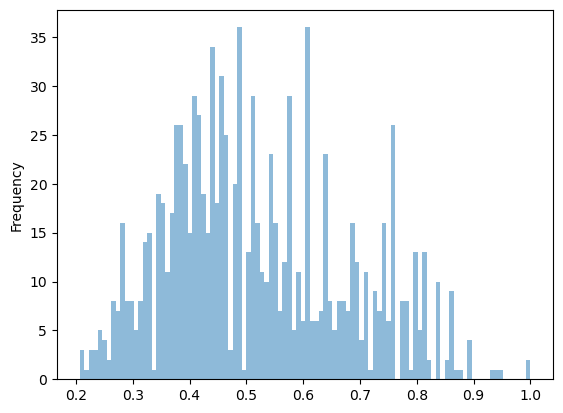

In [50]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [51]:
# TO COMPLETE
bleu_df = stats.sort_values(by=['bleu'],ascending=False).reset_index(drop=True)

#high score
print('High BLEU score:')
for ref in bleu_df.loc[0,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(bleu_df.loc[0,'preds']))
print('BLEU score: ',bleu_df.loc[0,'bleu'])

#low score
print('\nLow BLEU score:')
for ref in bleu_df.loc[len(bleu_df)-1,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(bleu_df.loc[len(bleu_df)-1,'preds']))
print('BLEU score: ',bleu_df.loc[len(bleu_df)-1,'bleu'])

High BLEU score:
Reference caption:  a man riding a motorcycle down a street
Reference caption:  a man sitting on a bike in front of a crowd of people
Reference caption:  military motorcycle driving past military personal in full dress uniforms and a observation stand filled with people in suits and military uniforms
Reference caption:  a solider in uniform riding a blue motorcycle during a ceremony
Reference caption:  a man is riding down the street on a motorcycle
Predicted sentence:  a man riding a motorcycle down a street
BLEU score:  1.0

Low BLEU score:
Reference caption:  a market where umbrellas are hung upside down
Reference caption:  a group of people shop inside a shopping tent with clothes and umbrellas
Reference caption:  a group of people that are under some umbrellas
Reference caption:  a group of people with several different umbrellas
Reference caption:  some umbrellas are all hanging up at a market
Predicted sentence:  a group of people standing on a beach next to a l

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [52]:
# -->embed get vector of each word: ref[[id,id,id,id],[id,id,id],[id,id,id]] ----> ref[[vec...],[vec,vec...],[vec]]
# compute avg: ref[[vec...],[vec,vec...],[vec]] ---> ref[[avg_vec1],[avg_vec2],[avg_vec3]]
# compute cos_sim: cos_sim=[[cos(avg_vec1,vec)],[],[]]
# compute avg cos as score: avg.cos_sim=[[cos(avg_vec1,vec)],[],[]]

In [53]:
# TO COMPLETE
def cos_sim(row):
    # word ---> id ----> tensor
    refs_words = row['ref']
    refs_ids = []
    for ref_words in refs_words:
        ref_ids = []
        for ref_word in ref_words:
            ref_ids.append(final_vocab(ref_word))
        refs_ids.append(ref_ids)
    #ref_tensor = torch.tensor(refs_ids)
    
    pred_words = row['preds']
    pred_ids = []
    for pred_word in pred_words:
        pred_ids.append(final_vocab(pred_word))
    pred_tensor = torch.tensor(pred_ids).to(device)
    
    # id_tensor ----> vector
    embed_layer = decoder.embed
    ref_vec = []
    for ref in refs_ids:
        ref_tensor = torch.tensor(ref).to(device)
        ref1_vec = embed_layer(ref_tensor).detach().cpu().numpy()
        ref_vec.append(ref1_vec)
    pred_vec = embed_layer(pred_tensor).detach().cpu().numpy()
    
    # vector ----> avg_vec
    ref_avg = [np.mean(x,axis=0) for x in ref_vec]
    pred_avg = np.mean(pred_vec,axis=0)
    
    # compute cos_sims
    cos_sims = []
    for i in range(len(ref_avg)):
        cos_sim = pred_avg.dot(ref_avg[i]) / (norm(pred_avg)*norm(ref_avg[i]))
        cos_sims.append(cos_sim)
    
    # avg cos_sims
    cos_sim = np.mean(cos_sims)
    return cos_sim

stats['cos_sim'] = stats.apply(cos_sim,axis=1)
stats.head()

ref  \
0  [[a, man, trimming, the, nails, of, a, sheep, ...   
1  [[an, upside, down, skateboarder, at, the, top...   
2  [[a, small, stuffed, bear, with, a, red, hat],...   
3  [[two, men, standing, in, a, field, holding, a...   
4  [[there, are, three, flowers, in, vases, by, a...   

                                               preds      bleu   cos_sim  
0  [a, group, of, brown, horses, standing, next, ...  0.795271  0.211122  
1  [a, man, with, a, baseball, bat, while, holdin...  0.508133  0.411213  
2  [a, man, and, woman, sitting, at, a, table, wi...  0.417226  0.469468  
3  [a, man, and, a, woman, standing, next, to, a,...  0.313142  0.209858  
4  [a, white, vase, filled, with, flowers, and, a...  0.776545  0.254013

Average cosine similarity score: 0.43310353


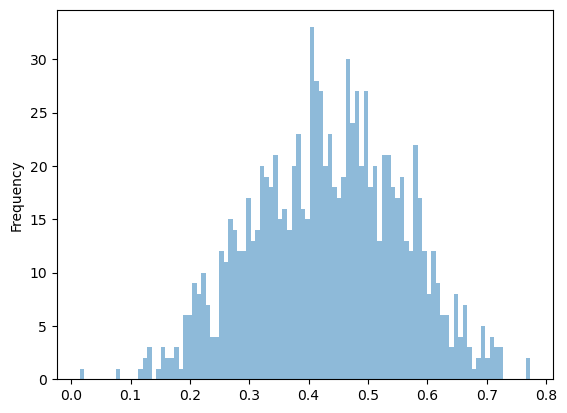

In [54]:
print("Average cosine similarity score:", stats['cos_sim'].mean())
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [55]:
# TO COMPLETE
cos_df = stats.sort_values(by=['cos_sim'],ascending=False).reset_index(drop=True)

#high score
print('High cosine similarity score:')
for ref in cos_df.loc[0,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(cos_df.loc[0,'preds']))
print('Cosine Similarity score: ',cos_df.loc[0,'cos_sim'])

#low score
print('\nLow cosine similarity score:')
for ref in cos_df.loc[len(cos_df)-1,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(cos_df.loc[len(cos_df)-1,'preds']))
print('Cosine Similarity score: ',cos_df.loc[len(cos_df)-1,'cos_sim'])

High cosine similarity score:
Reference caption:  a woman wearing black and white holds a tennis racket
Reference caption:  a young lady playing tennis on a tennis court
Reference caption:  a beautiful blond woman standing on top of a tennis court
Reference caption:  a close up of a tennis racket on a court
Reference caption:  a woman holding a tennis racket on a tennis court
Predicted sentence:  a woman holding a tennis racquet on a tennis court
Cosine Similarity score:  0.77372426

Low cosine similarity score:
Reference caption:  three people on horseback with the horse rearing
Reference caption:  two people that are riding two horses together
Reference caption:  three horses with riders are standing on their back legs in an arena
Reference caption:  rodeo horse riders are holding on for the crowd as the horses dance
Reference caption:  there are people watching three men on horseback
Predicted sentence:  a man riding a snowboard down a snow covered slope
Cosine Similarity score:  0.

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [56]:
# TO COMPLETE
# rescale
rescale_df = stats.copy()
rescale_df['cos_sim'] = rescale_df['cos_sim'].apply(lambda x: x if x>0 else 0)
rescale_df.head()

ref  \
0  [[a, man, trimming, the, nails, of, a, sheep, ...   
1  [[an, upside, down, skateboarder, at, the, top...   
2  [[a, small, stuffed, bear, with, a, red, hat],...   
3  [[two, men, standing, in, a, field, holding, a...   
4  [[there, are, three, flowers, in, vases, by, a...   

                                               preds      bleu   cos_sim  
0  [a, group, of, brown, horses, standing, next, ...  0.795271  0.211122  
1  [a, man, with, a, baseball, bat, while, holdin...  0.508133  0.411213  
2  [a, man, and, woman, sitting, at, a, table, wi...  0.417226  0.469468  
3  [a, man, and, a, woman, standing, next, to, a,...  0.313142  0.209858  
4  [a, white, vase, filled, with, flowers, and, a...  0.776545  0.254013

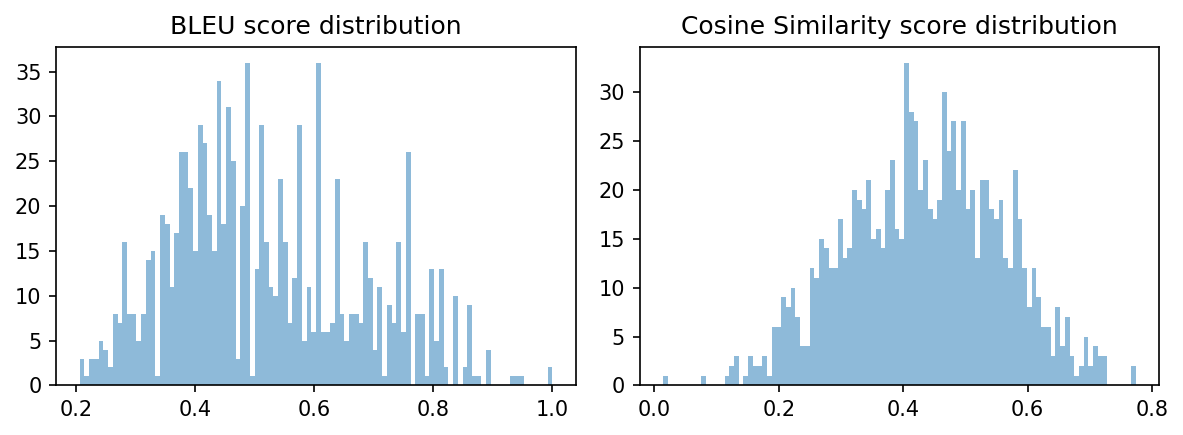

In [58]:
plt.figure(figsize=(8,3),dpi=150)
plt.subplot(1,2,1)
plt.hist(rescale_df['bleu'],bins=100, alpha=0.5)
plt.title('BLEU score distribution')
plt.subplot(1,2,2)
plt.hist(rescale_df['cos_sim'],bins=100, alpha=0.5)
plt.title('Cosine Similarity score distribution')
plt.tight_layout()
plt.show()

## Comment 7.1
#### BLUE
Weaknesses:  
1. Does not consider semantic and contextual information.  
2. Performs well on short sentences but poorly on long sentences. 

Strengths:  
1. Simple to use.  
2. Relatively intuitive.

#### Cosine similarity
Weaknesses:  
1. Limited by training corpus.
2. Only considers lexical similarity and ignores context. 

Strengths:  
1. Can capture lexical and semantic similarity.
2. Is not affected by sentence length.

 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [59]:
# compute different
rescale_df['diff'] = rescale_df.apply(lambda x: np.abs(x['bleu']-x['cos_sim']), axis=1)

rescale_sorted = rescale_df.sort_values(by='diff',ascending=True).reset_index(drop=True)
rescale_sorted.head()

ref  \
0  [[a, boy, jumping, a, skateboard, ramp, jump, ...   
1  [[a, red, small, engine, plane, in, motion, on...   
2  [[a, kitchen, with, white, cabinets, and, a, g...   
3  [[the, man, holding, a, surfboard, is, walking...   
4  [[a, couple, of, sheep, standing, on, a, lush,...   

                                               preds      bleu   cos_sim  \
0  [a, group, of, people, standing, in, front, of...  0.479878  0.479935   
1               [a, large, air, plane, on, a, field]  0.404952  0.405028   
2     [a, kitchen, with, a, sink, and, a, microwave]  0.634170  0.634493   
3         [a, couple, of, people, are, on, a, beach]  0.482402  0.481945   
4  [a, herd, of, animals, grazing, on, a, lush, g...  0.454994  0.455582   

       diff  
0  0.000057  
1  0.000077  
2  0.000323  
3  0.000457  
4  0.000588

In [60]:
#similar score
print('The example for both methods give similar scores:')
for ref in rescale_sorted.loc[0,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(rescale_sorted.loc[0,'preds']))
print('BLEU score: ',rescale_sorted.loc[0,'bleu'])
print('Cosine Similarity score: ',rescale_sorted.loc[0,'cos_sim'])

#different score
idx = len(rescale_sorted)-1
print('\nThe example for both methods give different scores:')
for ref in rescale_sorted.loc[idx,'ref']:
    print('Reference caption: ',' '.join(ref))
print('Predicted sentence: ',' '.join(rescale_sorted.loc[idx,'preds']))
print('BLEU score: ',rescale_sorted.loc[idx,'bleu'])
print('Cosine Similarity score: ',rescale_sorted.loc[idx,'cos_sim'])

The example for both methods give similar scores:
Reference caption:  a boy jumping a skateboard ramp jump in front of others
Reference caption:  young men at a skateboard park and one of them is making a jump
Reference caption:  a young man is doing a trick on a skateboard at a skate park
Reference caption:  a bunch of people watch a person do a trick on a skate board
Reference caption:  a group of hipsters hanging around a skate park
Predicted sentence:  a group of people standing in front of a crowd of people
BLEU score:  0.4798782066690664
Cosine Similarity score:  0.4799348711967468

The example for both methods give different scores:
Reference caption:  a cityscape of a korean city with crowds and neon lights
Reference caption:  groups of people walking through a brightly lit city
Reference caption:  a crowded downtown street in an asian city
Reference caption:  an image of a night scene with lots of people
Reference caption:  many people are walking through the streets of an asi

## Comment 7.2
Based on the comparison of reference and generated captions using two scoring metrics, it can be observed that BLEU primarily focuses on assessing the accuracy of individual words in generated captions. In contrast, cosine similarity not only accounts for word-level correctness but also evaluates semantic similarity between reference and generated captions. Therefore, it can be argued that using cosine similarity as an evaluation metric provides more informative and valuable results.